# Studying guided modes with PyMoosh

Modes are solutions of Maxwell's equations in a multilayered structure absent any source or any outside excitation. In order to find them, one has theoretically to solve the dispersion relation for a given $\omega$, and by doing so find the wavevector $k_x$ in the complex plane, and then to find the corresponding coefficients of the plane waves in each layer to represent the mode. The mode can be interpreted physically as an excitation which took place inside the structure at $\pm \infty$, and thus as a guided or a leaky mode. 

In the following, we will
1. Explain what modes are, exactly, and how we should derive them
2. Show what function to use to find guided modes, and how to represent them
3. Present a way to study the dispersion relation of these guided modes

## Dielectric waveguide

We first study the dielectric waveguide, constituted by a 600 nm thick layer of glass typically (with a refractive index of 1.5) surrounded with air. 

In [1]:
from PyMoosh import *
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150


structure = Structure([1.,2.25],[0,1,0],[0,600,200])

List of materials:
Simple, non dispersive: epsilon= 1.0
Simple, non dispersive: epsilon= 2.25


The wavelength in vaccum (which actually defines the frequency $\omega$) is taken to be $\lambda = 600$ nm. The effective index of a guided mode is defined by $$ n_\text{eff} = \frac{k_x}{k_0}$$ where $k_0 = \frac{2\pi}{\lambda} = \frac{\omega}{c}$. We take first a random effective index and find the value of the function `dispersion`

In [2]:
wavelength=600.
k_0 = 2*np.pi/wavelength
k_x = (1.0718280558+0.00000000001j)*k_0
f=dispersion(k_x,structure,wavelength,0)
print(k_x,f)

(0.011224157153375701+1.0471975511965976e-13j) 1.2585506192481664


In PyMoosh, we use a trick instead of solving the dispersion relation. We use the reflection coefficient and try to find the zeros of its inverse. Modes are actually poles of the reflection coefficient, so that finding the zeros of the inverse of the modulus of the reflection coefficient is enough. Since these zeros are minima of $\frac{1}{|r|}$, we can use a steepest descent (not the most effective way to find the zeros, probably) and we have a halting criterium (when $\frac{1}{|r|}$ is small enough). 

Remark: The determination of the square root in the outside medium has to be changed though, otherwise poles of the reflection coefficient can be hidden under another Riemann sheet.

In order to use PyMoosh's steepest descent, you have to know where to start in the complex plane (by giving the effective index, which can be complex), provide 



In [3]:
solution2 = steepest(1.05,1e-10,1000,structure,wavelength,0.)

In [4]:
#print(solution,dispersion(solution*k_0,structure,wavelength,0.))
print(solution2,dispersion(solution2*k_0,structure,wavelength,0.))

(1.0393548947630198-6.635754054764027e-15j) 2.5403703678492868e-12


### Mapping the reflection coefficient in the complex plane

In [6]:
#!pip show pymoosh

X,Y,T = complex_map(structure,wavelength,0.,[1.,1.6],[-0.3,0.3],200,200)

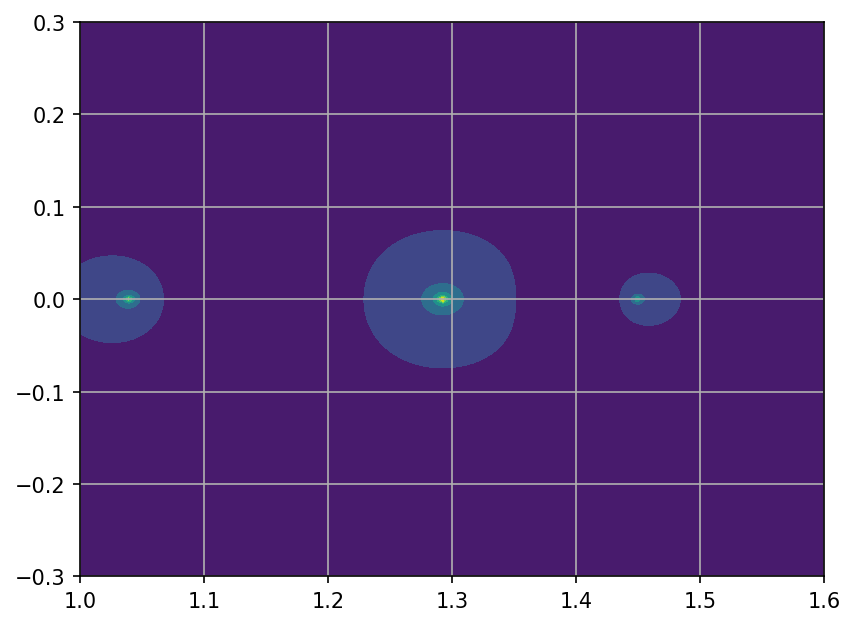

In [6]:
    plt.contourf(X,Y,np.sqrt(np.real(T)))
    plt.grid(True)
    plt.show()

### Finding the modes of the structure

Now there is an automated way to find the different modes in this structure without having to look at the map or launch by hand a few steepest descents to find their effective indexes. The function `Guided_modes` does just that, and gives all the different effectives indexes that satisfy the halting condition of the steepest descent.

In [7]:
modes = guided_modes(structure,wavelength,0,1.01,1.6)
print(modes)

[(1.0393548947633588+5.215398874172055e-13j), (1.2923307200596088-1.9254467390595312e-13j), (1.4491167148375674-5.074718085357839e-14j)]


Once the modes have been found, it is possible to access their profile. You have to specify the effective 

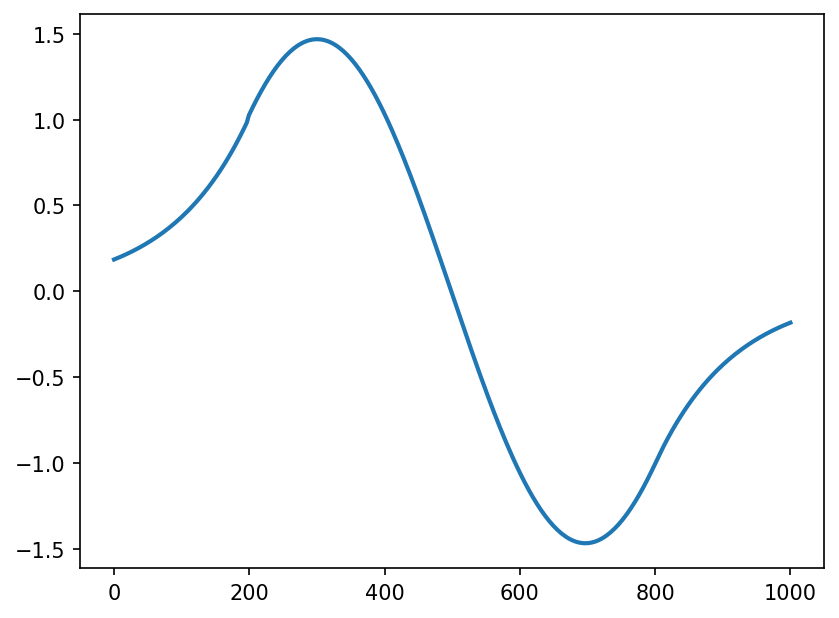

In [8]:
# Let first modify the thickness of the superstrat which is shown
structure.thickness[0]=200
x,prof = profile(structure,modes[1],wavelength,0)
plt.plot(x,np.real(prof),linewidth = 2)


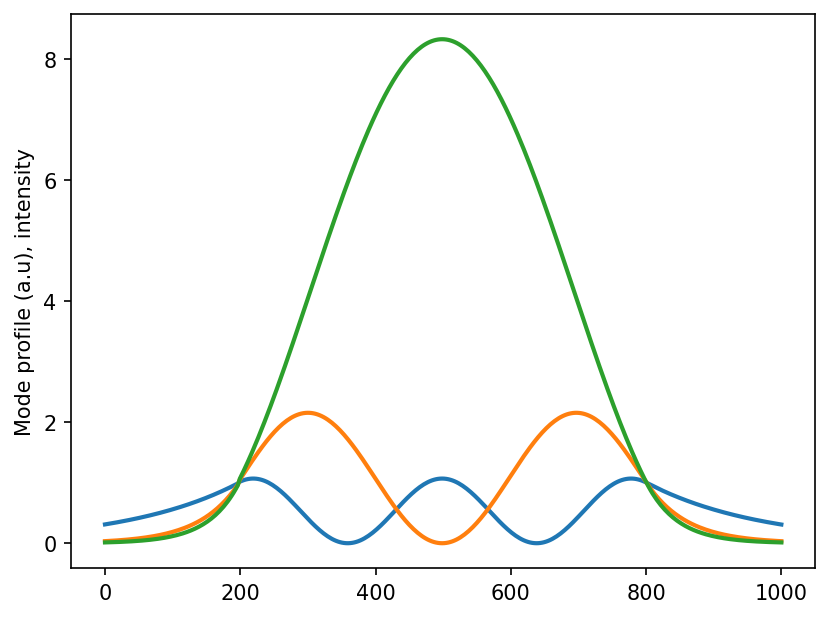

In [9]:
for k in range(len(modes)):
    x,prof = profile(structure,modes[k],wavelength,0)
    plt.plot(x,np.abs(prof)**2,linewidth = 2)
plt.ylabel('Mode profile (a.u), intensity')
plt.show()


## Coupled dielectric waveguides

Now, we will study quickly two coupled dielectric waaveguides, just for fun, because the modes are nice. First, as is obvious from the values of the effective index, the modes go in pair (a symetric and an antisymetric mode). Here, we had to increase the number of starting points for the steepest descent to 80, in order not to miss any mode.


In [10]:
coupled = Structure([1.,2.25],[0,1,0,1,0],[200,1200,300,1200,300])
modes = guided_modes(coupled,wavelength,0,1.00,1.6,initial_points = 80)
for k_x in modes:
    print(k_x)

List of materials:
Simple, non dispersive: epsilon= 1.0
Simple, non dispersive: epsilon= 2.25
(1.0519784599008872-7.353022218622634e-14j)
(1.0757797228861667+1.9085477980453106e-13j)
(1.2238194522087973-1.467562687920135e-13j)
(1.2333329899593408-1.001519890529636e-12j)
(1.349566984849598-9.810705882071017e-15j)
(1.3531192983382774-8.944438174790887e-15j)
(1.4345907747798436+1.8541601776592068e-14j)
(1.4357768692631023+2.4473581171518107e-13j)
(1.4838530457134158-1.4708403218407295e-14j)
(1.4841039261240145-4.751612114315212e-14j)


Now that we are sure we have all the modes, let's represent them :

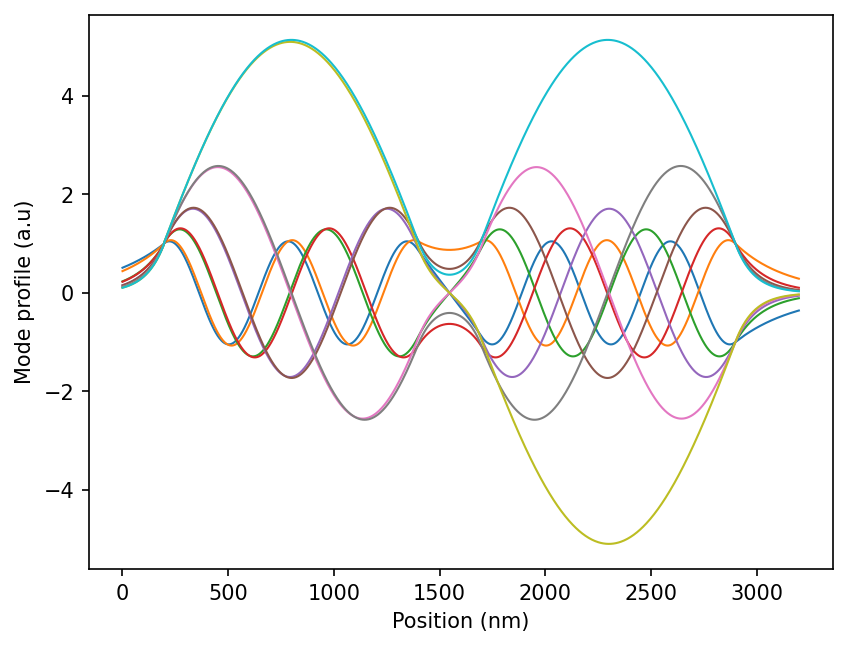

In [11]:
for k in range(len(modes)):
    x,prof = profile(coupled,modes[k],wavelength,0)
    plt.plot(x,np.real(prof),linewidth = 1)
plt.ylabel('Mode profile (a.u)')
plt.xlabel('Position (nm)')
plt.show()


## Surface plasmon

An emblematic guided mode is the "surface plasmon" or sometimes "surface plasmon polariton". We will keep the "surface plasmon" denomination, because this kind of surface wave propagating at the surface of a metal is not a plasmon, strictly speaking and even less a polariton. The problem for PyMoosh is that it assumes that there is more than just one interface in the structure. You thus have to invent one, in the middle of nowhere. Here, we add one in the silver after 0 nm. Not that we are in TM polarization here.

In [12]:
metallic_interface = Structure([1.,'Gold'],[0,1,1],[1000,0,100])
wavelength = 600
modes = guided_modes(metallic_interface,wavelength,1,1.000,1.3)
print(modes)

List of materials:
Simple, non dispersive: epsilon= 1.0
Database material: Gold, model: Brendel Bormann
[(1.0629502930842754+0.011545733506290977j)]


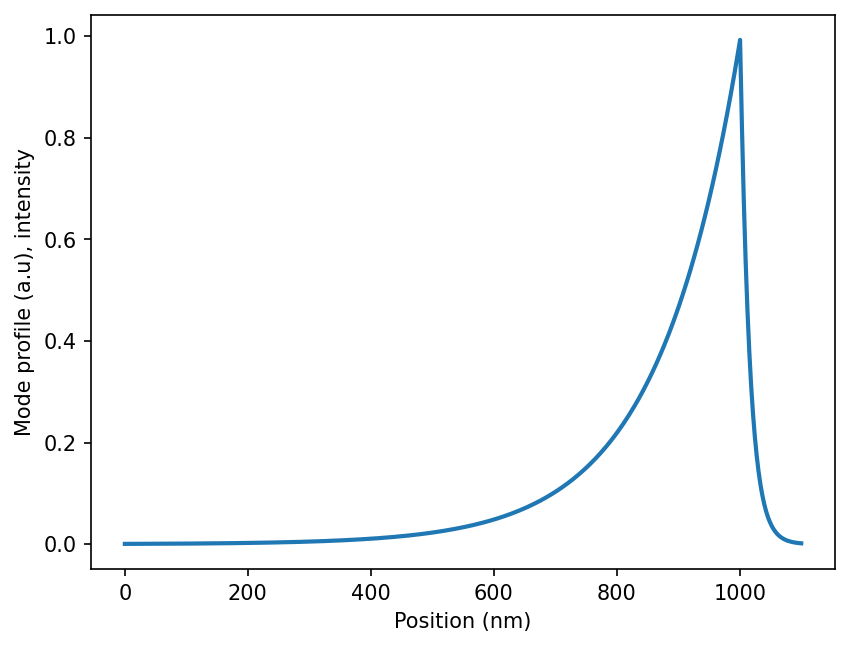

In [13]:
x,prof = profile(metallic_interface,modes[0],wavelength,1)
plt.plot(x,np.abs(prof)**2,linewidth = 2)
plt.ylabel('Mode profile (a.u), intensity')
plt.xlabel('Position (nm)')
plt.show()


As you can see, the effective index of the surface plasmon is not very high. Which is a pity, because this means there will not be much miniaturization to expect from surface plasmon based cavities. We can try with a gap-plasmon...

## Gap-plasmon

More challenging, we will now try to find the mode (it's unique) which is able to propagate in a nanometric space between two metallic regions. In this regime, the mode propagates almost more inside the metal than in the dielectric. As a consequence, it is slowed down by the metal (the Poynting vector is negative inside the metal and the mean Poynting vector is in fact linked to the group velocity). While there is air in the gap, the effective index of the mode can go much higher than in any dielectric material. 

In [14]:
gap = Structure([1.,'Gold'],[1,0,1],[50,3,50])
wavelength = 600
gap_plasmon = steepest(4,1e-12,10000,gap,wavelength,1.)
print(gap_plasmon)

List of materials:
Simple, non dispersive: epsilon= 1.0
Database material: Gold, model: Brendel Bormann
(7.960496625410466+1.0996191466348815j)


The effective index is as high as 8, with a massive imaginary part, for a 3 nm wide gap. Which is not much. `Guided_modes` will fail here because its limited number of steps before giving up does not allow it to reach the effective index of the mode. Hence the direct use of the steepest descent with adapted parameters (and a maximum number  of step of 10000). In order to represent the mode correctly, one has to adapt the size of a pixel and take it down to 0.1 nm.

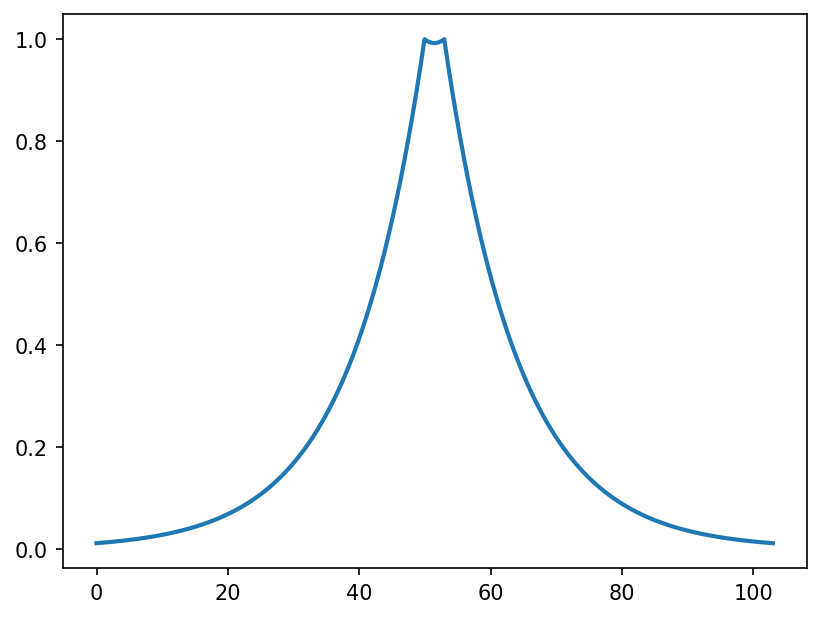

In [15]:
x,prof = profile(gap,gap_plasmon,wavelength,1,pixel_size = 0.1)
plt.plot(x,np.real(prof),linewidth = 2)


## Following the guided modes

If we work at a specific wavelength, the above methods are enough to know all we need to know about the guided modes.

However, it is often important to know how these modes depend on the incoming light's wavelength. This is what the **follow_guided_modes(...)** function does:

List of materials:
Simple, non dispersive: epsilon= 1.0
Simple, non dispersive: epsilon= 2.25
Simple, non dispersive: epsilon= 2


/home/denis/miniconda3/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


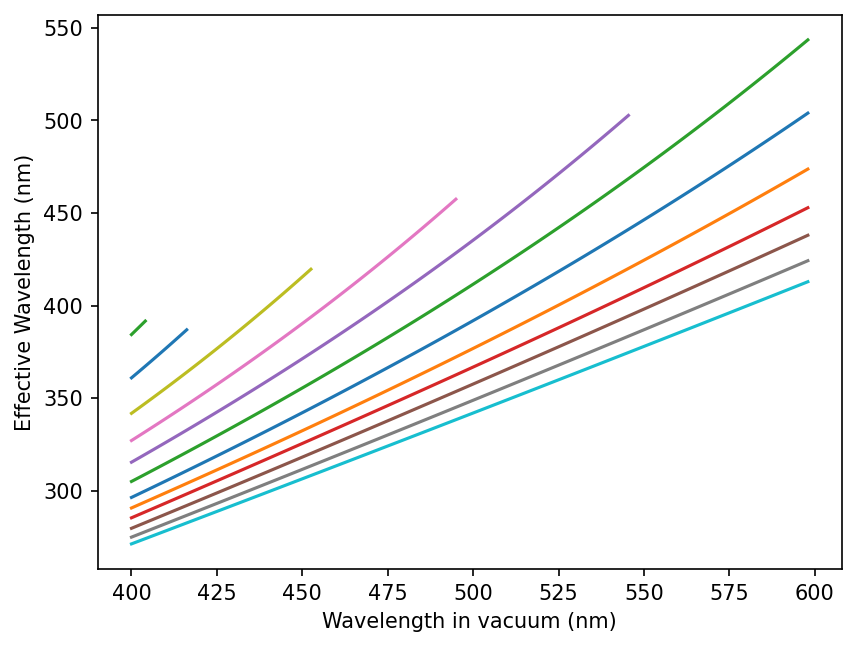

[[(1+0j), (1.0408272610505593+6.776830077120769e-13j), (1.108291489567999+4.822126784277349e-13j), (1.1704503446275483+1.995310418824006e-14j), (1.223028921526407-4.1387483642972705e-14j), (1.2684379246813806-3.4119600187373086e-13j), (1.3117427202654728-2.7693163477082637e-13j), (1.3499166965179905+6.193686839853861e-14j), (1.3763393383720055+2.083696486350833e-13j), (1.4019762814110623-1.747379691527713e-13j), (1.430446083232238-6.761818498881089e-15j), (1.455261845152305+1.4853387434392054e-14j), (1.4748168115226532-2.0800097206824434e-13j), (1.4972046409762776-1.7960718750462853e-16j)], array([1.        +0.00000000e+00j, 1.0362973 -1.77896203e-13j,
       1.10428369-1.95680539e-13j, 1.16715103+1.25516213e-13j,
       1.22039813-4.30606021e-13j, 1.26629566+5.48606749e-14j,
       1.30999716-8.99865860e-14j, 1.34863781-4.13761016e-14j,
       1.37550632+1.89659523e-13j, 1.40118126+4.18542723e-14j,
       1.42982356-8.16724815e-15j, 1.45485157+4.96793747e-14j,
       1.47458416+1.5524

In [16]:
mat = 1.5
materials = [1., mat**2, 2]

incidence = 0*np.pi/180

structure = np.array([2000, 500])
epaisseurs = np.concatenate(([0],structure,[0]))
stack = [0,1, 2, 0]

wavs = np.linspace(400, 600, 100)
neff_min, neff_max = 1., 2.


chose = Structure(materials, stack, epaisseurs)

indices, follow_modes = follow_guided_modes(chose, wavs, 0, neff_min, neff_max, format="n", plot=True)
print(indices)